# Auto autónomo
Realizaremos la simulación de un auto autónomo (Smartcab). El objetivo principal es demostrar, en un entorno simplificado, cómo se pueden utilizar las técnicas de RL para desarrollar un enfoque eficaz y seguro para abordar este problema.

El trabajo del Smartcab es recoger al pasajero en un lugar y dejarlo en otro. Aquí hay algunas cosas de las que nos encantaría que se ocupara nuestra Smartcab:

 - Deje al pasajero en el lugar correcto.
 - Ahorre tiempo al pasajero tomando el mínimo tiempo posible para dejar
 - Cuide la seguridad de los pasajeros y las normas de tránsito.

Como ya vimos, hay diferentes aspectos que deben considerarse aquí al modelar una solución de RL para este problema: recompensas, estados y acciones.

## 1. Recompensas
Dado que el agente (el conductor imaginario) está motivado por las recompensas y va a aprender a controlar la cabina mediante experiencias de prueba en el entorno, debemos decidir las recompensas y/o sanciones y su magnitud en consecuencia. Aquí algunos puntos a considerar:

 - El agente debe recibir una alta recompensa positiva por un abandono exitoso porque este comportamiento es muy deseado
 - El agente debe ser penalizado si intenta dejar a un pasajero en lugares incorrectos.
 - El agente debería obtener una recompensa levemente negativa por no llegar al destino después de cada paso de tiempo. "Ligeramente" negativo porque preferiríamos que nuestro agente llegara tarde en lugar de hacer movimientos equivocados tratando de llegar al destino lo más rápido posible

## 2. Estados
En el aprendizaje por refuerzo, el agente se encuentra con un estado y luego actúa de acuerdo con el estado en el que se encuentra.

El State Space es el conjunto de todas las situaciones posibles en las que podría vivir nuestro taxi. El estado debe contener información útil que el agente necesita para realizar la acción correcta.

Digamos que tenemos un área de entrenamiento para nuestro Smartcab donde le estamos enseñando a transportar personas en un estacionamiento a cuatro ubicaciones diferentes (R, G, Y, B):

![title](auto_autonomo.png)

Supongamos que Smartcab es el único vehículo en este estacionamiento. Podemos dividir el estacionamiento en una cuadrícula de 5x5, lo que nos da 25 posibles ubicaciones de taxis. Estas 25 ubicaciones son una parte de nuestro espacio de estados. Observemos que el estado de ubicación actual de nuestro taxi es la coordenada (3, 1).

También notarán que hay cuatro (4) ubicaciones en las que podemos recoger y dejar a un pasajero: R, G, Y, B o [(0,0), (0,4), (4,0), (4,3)] en las coordenadas (fila, columna). Nuestro pasajero ilustrado está en una ubicación Y y desea ir a la ubicación R .

Contabilizando un (1) estado adicional de pasajero dentro del taxi, podemos tomar todas las combinaciones de ubicaciones de pasajeros y ubicaciones de destino para llegar a un número total de estados para nuestro entorno de taxi; hay cuatro (4) destinos y cinco (4 + 1) ubicaciones de pasajeros.

Entonces, nuestro entorno de taxis ha 5 × 5 × 5 × 4 = 500 estados posibles totales.

## 3. Acciones

El agente se encuentra con uno de los 500 estados y realiza una acción. La acción en nuestro caso puede ser moverse en una dirección o decidir recoger / dejar a un pasajero.

En otras palabras, tenemos seis acciones posibles:

 1. south
 2. north
 3. east
 4. west
 5. pickup
 6. dropoff

Este es el espacio de acción : el conjunto de todas las acciones que nuestro agente puede realizar en un estado determinado.

Notarán en la ilustración de arriba, que el taxi no puede realizar ciertas acciones en ciertos estados debido a las paredes. En el código del entorno, simplemente proporcionaremos una penalización de -1 por cada "golpe" a la pared y el taxi no se moverá a ningún lado. Esto solo acumulará multas y hará que el taxi considere dar la vuelta a la pared.

## Implementación con Python

Afortunadamente, OpenAI Gym ya tiene este entorno exacto construido para nosotros.

Gym proporciona diferentes entornos de juego que podemos conectar a nuestro código y probar un agente. La biblioteca se encarga de la API para proporcionar toda la información que nuestro agente requeriría, como posibles acciones, puntaje y estado actual. Solo necesitamos enfocarnos en la parte del algoritmo para nuestro agente.

Usaremos el entorno Gym llamado Taxi-V3, del que se extrajeron todos los detalles explicados anteriormente. Los objetivos, recompensas y acciones son todos iguales.

## Interfaz del gimnasio

Necesitamos primero instalar gym. Como sabemos eso podemos hacerlo mediante pip:
```bash
pip install cmake 'gym[atari]' scipy
```

Una vez instalado, podemos cargar el entorno del juego y renderizarlo:

In [1]:
import gym

env = gym.make("Taxi-v3").env

env.render()


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



La interfaz principal del gimnasio es env, que es la interfaz del entorno unificado. Los siguientes son los envmétodos que nos serían de gran ayuda:

 - `env.reset`: Restablece el entorno y devuelve un estado inicial aleatorio.
 - `env.step(action)`: Paso el entorno en un paso de tiempo. Devoluciones
     - <b>observación</b> : Observaciones del medio ambiente
     - <b>recompensa</b> : si su acción fue beneficiosa o no
     - <b>done</b> : Indica si hemos recogido y dejado a un pasajero, también llamado episodio
     - <b>info</b> : información adicional como el rendimiento y la latencia para fines de depuración
 - `env.render`: Renderiza un fotograma del entorno (útil para visualizar el entorno)

## Recordatorio de nuestro problema
Aquí está nuestra declaración de problema reestructurada (de los documentos de Gym):

<i>"Hay 4 ubicaciones (etiquetadas con letras diferentes) y nuestro trabajo es recoger al pasajero en una ubicación y dejarlo en otra. Recibimos +20 puntos por una entrega exitosa y perdemos 1 punto por cada  paso que da. También hay una penalización de 10 puntos por acciones ilegales de recoger y dejar ".</i>

Adentremonos más en la librería



In [2]:
env.reset()  # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


 - El <b>cuadrado relleno</b> representa el taxi, que es amarillo sin pasajero y verde con pasajero.
 - La <b>línea ("|")</b> representa una pared que el taxi no puede cruzar.
 - <b>R, G, Y, B</b> son las posibles ubicaciones de recogida y destino. La <b>letra azul</b> representa la ubicación actual de recogida de pasajeros y la <b>letra rosa</b> es el destino actual.

Según lo verificado por los output, tenemos un <b>Action Space</b> de tamaño 6 y un <b>State Space</b> de tamaño 500. Como verá, nuestro algoritmo RL no necesitará más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de forma única asignando un número único a cada estado posible, y RL aprende a elegir un número de acción del 0 al 5 donde:

 - 0 = sur
 - 1 = norte
 - 2 = este
 - 3 = oeste
 - 4 = recogida
 - 5 = abandono

Recuerden que los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación de destino.

El aprendizaje por refuerzo aprenderá un mapeo de <b>estados</b> para la <b>acción</b> óptima a realizar en ese estado por exploración , es decir, el agente explora el entorno y toma acciones basadas en recompensas definidas en el entorno.

La acción óptima para cada estado es la acción que tiene la <b>recompensa acumulada más alta a largo plazo </b> .

## Volvamos a nuestra ilustración

De hecho, podemos tomar nuestra ilustración anterior, codificar su estado y dárselo al entorno para que se renderice en Gym. Recuerde que tenemos el taxi en la fila 3, columna 1, nuestro pasajero está en la ubicación 2 y nuestro destino es la ubicación 0. Usando el método de codificación de estado Taxi-v2, podemos hacer lo siguiente:

In [3]:
state = env.encode(
    3, 1, 2, 0
)  # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Estamos usando las coordenadas de nuestra ilustración para generar un número correspondiente a un estado entre 0 y 499, que resulta ser 328 para el estado de nuestra ilustración.

Luego, podemos establecer el estado del entorno manualmente `env.s` usando ese número codificado. Puede jugar con los números y verá que el taxi, el pasajero y el destino se mueven.

## Recompensas

Cuando se crea el entorno Taxi, también se crea una tabla de recompensas inicial, llamada "P". Podemos pensar en ello como una matriz que tiene el número de estados como filas y el número de acciones como columnas, es decir, una matriz de estados x acciones.

Dado que cada estado está en esta matriz, podemos ver los valores de recompensa predeterminados asignados al estado de nuestra ilustración:

In [4]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura```{action: [(probability, nextstate, reward, done)]}```.

Algunas cosas a tener en cuenta:

 - El 0-5 corresponde a las acciones (sur, norte, este, oeste, recogida, bajada) que el taxi puede realizar en nuestro estado actual en la ilustración.
 - En este entorno, `probability` siempre es 1.0.
 - El `nextstate` es el estado en el que estaríamos si tomamos la acción en este índice del dict
 - Todas las acciones de movimiento tienen una recompensa de -1 y las acciones de recoger / dejar tienen una recompensa de -10 en este estado en particular. Si estamos en un estado en el que el taxi tiene un pasajero y está en la parte superior del destino correcto, veríamos una recompensa de 20 en la acción de devolución (5)
 - `done` se utiliza para indicarnos cuándo hemos dejado a un pasajero en el lugar correcto. Cada abandono exitoso es el final de un <b>episodio</b>.

Tenga en cuenta que si nuestro agente eligiera explorar la acción dos (2) en este estado, estaría yendo hacia el este contra una pared. El código fuente ha hecho imposible mover el taxi a través de una pared, por lo que si el taxi elige esa acción, seguirá acumulando -1 penalizaciones, lo que afecta la <b>recompensa a largo plazo</b>.

## Resolver el entorno sin aprendizaje por refuerzo
Veamos qué pasaría si intentamos utilizar la fuerza bruta para resolver el problema sin RL.

Dado que tenemos nuestra `P` tabla de recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo con eso.

Crearemos un bucle infinito que se ejecutará hasta que un pasajero llegue a un destino (un episodio ), o en otras palabras, cuando la recompensa recibida sea 20. El `env.action_space.sample()` método selecciona automáticamente una acción aleatoria del conjunto de todas las acciones posibles.

Veamos qué pasa:



In [5]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = []  # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append(
        {
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward,
        }
    )

    epochs += 1


print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 493
Penalties incurred: 140


In [6]:
from IPython.display import clear_output
from time import sleep


def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.1)


print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 493
State: 0
Action: 5
Reward: 20


No está bien. Nuestro agente toma miles de pasos de tiempo y realiza muchas entregas incorrectas para entregar un solo pasajero al destino correcto.

Esto se debe a que no estamos aprendiendo de experiencias pasadas. Podemos ejecutar esto una y otra vez, y nunca se optimizará. El agente no tiene memoria de qué acción fue la mejor para cada estado, que es exactamente lo que hará por nosotros el Aprendizaje por refuerzo.

## Añadiendo aprendizaje por refuerzo
Vamos a utilizar un algoritmo RL simple llamado Q-learning que le dará a nuestro agente algo de memoria.

### Refrescando Q-learning
Básicamente, Q-learning permite al agente usar las recompensas del entorno para aprender, con el tiempo, la mejor acción a tomar en un estado determinado.

En nuestro entorno de Taxi, tenemos la tabla de recompensas `P`, de la que el agente aprenderá. Lo hace buscando recibir una recompensa por realizar una acción en el estado actual y luego actualizar un valor Q para recordar si esa acción fue beneficiosa.

Los valores almacenados en la tabla Q se denominan valores Q y se asignan a una `(state, action)` combinación.

Un valor Q para una combinación particular de estado-acción es representativo de la "calidad" de una acción tomada desde ese estado. Mejores valores de Q implican mejores posibilidades de obtener mayores recompensas.

Por ejemplo, si el taxi se enfrenta a un estado que incluye a un pasajero en su ubicación actual, es muy probable que el valor Q de `pickup` sea mayor en comparación con otras acciones, como `dropoff` o `north`.

Los valores Q se inicializan a un valor arbitrario y, a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los valores Q se actualizan mediante la ecuación:

###  Q(state,action)←(1−α)Q(state,action)+α(reward+γ max(a)Q(next state,all actions))

Dónde:

- <b>α</b> (alfa) es la tasa de aprendizaje (0 < α ≤ 1) - Al igual que en entornos de aprendizaje supervisado, α es la medida en que nuestros valores Q se actualizan en cada iteración.

- <b>γ</b> (gamma) es el factor de descuento (0 ≤ γ≤ 1): determina la importancia que queremos dar a las recompensas futuras. Un valor alto para el factor de descuento (cercano a 1 ) captura la recompensa efectiva a largo plazo, mientras que un factor de descuento de 0 hace que nuestro agente considere solo la recompensa inmediata, lo que lo hace codicioso.

## ¿Qué está diciendo esto?

Estamos asignando (←), o actualizar, el valor Q del estado actual del agente y la acción tomando primero un peso (1 - α) del antiguo valor Q, luego agregando el valor aprendido. El valor aprendido es una combinación de la recompensa por realizar la acción actual en el estado actual y la recompensa máxima descontada del siguiente estado en el que estaremos una vez que realicemos la acción actual.

Básicamente, estamos aprendiendo la acción adecuada a tomar en el estado actual al observar la recompensa por el combo estado / acción actual y las recompensas máximas para el siguiente estado. Esto eventualmente hará que nuestro taxi considere la ruta con las mejores recompensas juntas.

El valor Q de un par estado-acción es la suma de la recompensa instantánea y la recompensa futura descontada (del estado resultante). La forma en que almacenamos los valores Q para cada estado y acción es a través de una <b>tabla Q</b>

## Q-Table

La tabla Q es una matriz donde tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0 y luego los valores se actualizan después del entrenamiento. Tenga en cuenta que la Q-table tiene las mismas dimensiones que la mesa de recompensas, pero tiene un propósito completamente diferente.

![title](q-matrix.png)

*Los valores de Q-Table se inicializan a cero y luego se actualizan durante el entrenamiento a valores que optimizan el recorrido del agente por el entorno para obtener las máximas recompensas.*

## Resumiendo el proceso de Q-Learning

Dividiéndolo en pasos, obtenemos

 - Inicializa la tabla Q por todos los ceros.
 - Empiece a explorar acciones: para cada estado, seleccione cualquiera de las posibles acciones para el estado actual (S).
 - Viaja al siguiente estado (S ') como resultado de esa acción (a).
 - Para todas las acciones posibles del estado (S '), seleccione la que tenga el valor Q más alto.
 - Actualice los valores de la tabla Q utilizando la ecuación.
 - Establezca el siguiente estado como el estado actual.
 - Si se alcanza el estado objetivo, finalice y repita el proceso.

## Explotación de valores aprendidos

Después de suficiente exploración aleatoria de acciones, los valores Q tienden a converger sirviendo a nuestro agente como una función de valor de acción que puede explotar para elegir la acción más óptima de un estado dado.

Como vimos en la teórica existe un tradeoff entre exploración (elegir una acción aleatoria) y explotación (elegir acciones basadas en valores Q ya aprendidos). Queremos evitar que la acción tome siempre la misma ruta y posiblemente sobreajuste, por lo que introduciremos otro parámetro llamado ϵ "épsilon" para atender esto durante el entrenamiento.

En lugar de simplemente seleccionar la acción de valor Q mejor aprendida, a veces preferimos explorar más el espacio de acción. Un valor épsilon más bajo da como resultado episodios con más penalizaciones (en promedio), lo cual es obvio porque estamos explorando y tomando decisiones al azar.

## Implementando Q-learning en Python

### Entrenando al Agente
Primero, inicializaremos la Q-table a un 500 × 6 matriz de ceros:

In [7]:
import numpy as np

In [8]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ahora podemos crear el algoritmo de entrenamiento que actualizará esta Q-table a medida que el agente explora el entorno durante miles de episodios.

En la primera parte de `while not done `, decidimos si elegir una acción aleatoria o explotar los valores Q ya calculados. Esto se hace simplemente usando el `epsilon` valor y comparándolo con la `random.uniform(0, 1`función, que devuelve un número arbitrario entre 0 y 1.

Ejecutamos la acción elegida en el entorno para obtener el `next_state`y el `reward` de realizar la acción. Después de eso, calculamos el valor Q máximo para las acciones correspondientes a `next_state`, y con eso, podemos actualizar fácilmente nuestro valor Q a `new_q_value`:

In [9]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 36.2 s, sys: 1.18 s, total: 37.4 s
Wall time: 36.3 s


Ahora que la tabla Q se ha establecido en más de 100.000 episodios, veamos cuáles son los valores Q en el estado de nuestra ilustración:

In [10]:
q_table[328]

array([ -2.39873797,  -2.27325184,  -2.40661702,  -2.35772065,
        -9.9475546 , -10.67226605])

El valor máximo de Q es "norte" (-2,273, puede variar en cada corrida), por lo que parece que Q-learning ha aprendido efectivamente la mejor acción a realizar en el estado de nuestra ilustración.

## Evaluando al agente

Evaluemos el desempeño de nuestro agente. No necesitamos explorar más acciones, por lo que ahora la siguiente acción siempre se selecciona utilizando el mejor valor Q:



In [11]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 13.02
Average penalties per episode: 0.0


Podemos ver en la evaluación que el desempeño del agente mejoró significativamente y no incurrió en penalizaciones, lo que significa que realizó las acciones correctas de recogida / devolución con 100 pasajeros diferentes.

## Hiperparámetros y optimizaciones
Los valores de `alpha`,` gamma` y `epsilon` se basaron principalmente en la intuición y en algunos "hit and trial", pero hay mejores formas de obtener buenos valores.

Idealmente, los tres deberían disminuir con el tiempo porque a medida que el agente continúa aprendiendo, en realidad construye antecedentes más resistentes;

 - α: (la tasa de aprendizaje) debería disminuir a medida que continúa adquiriendo una base de conocimientos cada vez más amplia.
 - γ: a medida que se acerca más y más al final, su preferencia por la recompensa a corto plazo debería aumentar, ya que no estará el tiempo suficiente para obtener la recompensa a largo plazo, lo que significa que su gamma debería disminuir.
 - ϵ: a medida que desarrollamos nuestra estrategia, tenemos menos necesidad de exploración y más explotación para obtener más utilidad de nuestra política, por lo que a medida que aumentan los ensayos, épsilon debería disminuir.

## Ajuste de los hiperparámetros

Una forma sencilla de generar mediante programación el mejor conjunto de valores del hiperparámetro es crear una función de búsqueda integral (similar a grid search) que seleccione los parámetros que darían como resultado la mejor proporción de recompensa/pasos. El motivo por el que establecemos recompensa/pasos es que queremos elegir parámetros que nos permitan obtener la máxima recompensa lo más rápido posible. Es posible que también deseemos realizar un seguimiento del número de penalizaciones correspondientes a la combinación de valores de hiperparámetro porque esto también puede ser un factor decisivo (no queremos que nuestro agente inteligente viole las reglas a costa de llegar más rápido). Una forma más elegante de obtener la combinación correcta de valores de hiperparámetros sería usar algoritmos genéticos (no lo vimos pero para que sepan).

## Conclusión

Q-learning es uno de los algoritmos de aprendizaje por refuerzo más fáciles. Sin embargo, el problema con Q-earning es que, una vez que el número de estados en el entorno es muy alto, se vuelve difícil implementarlos con Q table ya que el tamaño se volvería muy, muy grande. Las técnicas de vanguardia utilizan redes neuronales profundas en lugar de Q-table (aprendizaje por refuerzo profundo). La red neuronal recibe información de estado y acciones en la capa de entrada y aprende a generar la acción correcta a lo largo del tiempo. Las técnicas de aprendizaje profundo (como las redes neuronales convolucionales) también se utilizan para interpretar los píxeles en la pantalla y extraer información del juego (como puntuaciones), y luego dejar que el agente controle el juego.

Hemos hablado mucho sobre el aprendizaje por refuerzo y los juegos. Pero el aprendizaje por refuerzo no se limita solo a los juegos. Se utiliza para gestionar carteras de valores y finanzas, para hacer robots humanoides, para la fabricación y la gestión de inventarios, para desarrollar agentes de IA generales, que son agentes que pueden realizar varias cosas con un solo algoritmo, como el mismo agente que juega varios juegos de Atari. Open AI también tiene una plataforma llamada universo para medir y entrenar la inteligencia general de una IA en miles de juegos, sitios web y otras aplicaciones generales.

## Para que sigan ustedes
Si quieren continuar con este proyecto para mejorarlo, aqcá hay algunas cosas que puede agregar:

 - Conviertir este código en un módulo de funciones que puede usar múltiples entornos
 - Tunear alfa, gamma y / o épsilon usando un decay sobre episodios
 - Implementar un grid search para descubrir los mejores hiperparámetros
 - Usar otro enviroments! https://gym.openai.com/envs


In [12]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

In [13]:
import time

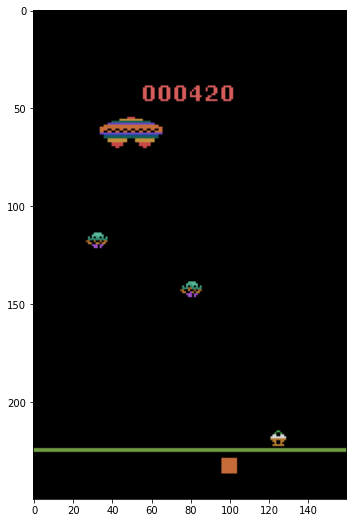

In [14]:
env = gym.make('Assault-ram-v0')
env.reset()
plt.figure(figsize=(9, 9))
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(1000):
    img.set_data(env.render(mode='rgb_array'))  # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.step(env.action_space.sample())  # take a random action
    time.sleep(0.005)
env.close()